In [120]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from montecarlo import *
from portfolio import *

PERIODS = 252
dur = 20
riskFreeRate = 0.01


In [210]:
# data = pd.read_csv('quotes_clean_mach1.csv')  # daily quotes assets_all
#data = pd.read_csv('quote_mach2.csv')  # daily quotes assets_all
#data['dateTime'] = pd.to_datetime(data['dateTime'])
#data.set_index('dateTime', inplace=True)
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau'] # **
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['iusa','imeu','ibtm','xgle','phau']

data = read_quotes(assets)
numAssets = len(assets)
# data.head()

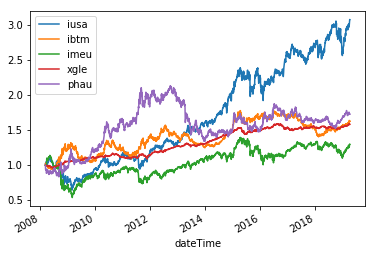

In [211]:
norm_data = data/data.iloc[0]
norm_data.plot()

In [212]:
# correzione SMEA
if 'smea' in assets:
    x1 = data.smea.idxmin()
    data.smea.loc[x1] = data.smea.loc[x1 - pd.Timedelta(days=1)]


In [219]:
## *DAILY* returns
## LOG
x = data/data.shift(1)
x.dropna(inplace=True)
returns = np.log(x)

## PCT
#returns = norm_data.pct_change()
#returns.dropna(inplace=True)

meanDailyReturns = returns[assets].mean()
covMatrix = returns[assets].cov()
# meanDailyReturns

In [220]:
#Run MC simulation of numPortfolios portfolios

numPortfolios = 2500
results = np.zeros((3,numPortfolios))

#Calculate portfolios

for i in range(numPortfolios):
    #Draw numAssets random numbers and normalize them to be the portfolio weights

    weights = np.random.random(numAssets)
    weights /= np.sum(weights)

    #Calculate expected return and volatility of portfolio

    pret, pvar = calcPortfolioPerf(weights, meanDailyReturns, covMatrix, PERIODS)

    #Convert results to annual basis, calculate Sharpe Ratio, and store them

    results[0,i] = pret
    results[1,i] = pvar
    results[2,i] = (results[0,i] - riskFreeRate)/results[1,i]

In [221]:
targetReturns = np.linspace(0.02, 0.12, 20)
efficientPortfolios = findEfficientFrontier(meanDailyReturns, 
                                            covMatrix, targetReturns, PERIODS)

In [222]:
#Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio( meanDailyReturns, covMatrix,
                                        riskFreeRate, PERIODS)
retms, sdms = calcPortfolioPerf(maxSharpe['x'], meanDailyReturns, covMatrix, PERIODS)

#Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturns, covMatrix, PERIODS)
retmv, sdmv = calcPortfolioPerf(minVar['x'], meanDailyReturns, covMatrix, PERIODS)

In [223]:
### PLOTTING

dfResults = pd.DataFrame(results.T)
dfResults.columns = ['ret','vola','sharpe']

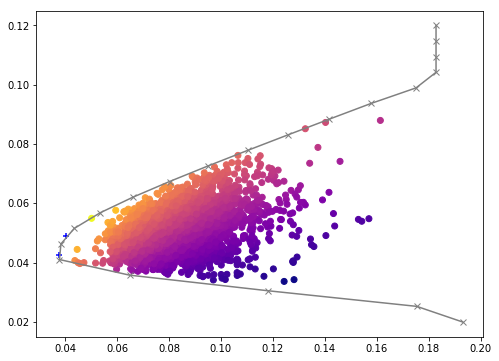

In [224]:
fig10 = plt.figure(figsize = (8,6))


plt.scatter(dfResults.vola, dfResults.ret, c = dfResults.sharpe, 
            marker = 'o', cmap='plasma')

# plt.scatter(maxPtfls.vola, maxPtfls.ret, c='blue', marker = '+')

plt.scatter(sdms, retms, c='blue', marker='+')
plt.scatter(sdmv, retmv, c='blue', marker='+')

plt.plot([p['fun'] for p in efficientPortfolios], 
         targetReturns, marker='x', c='gray')

plt.show();



In [225]:
dfResults.iloc[dfResults.sharpe.idxmax()]

ret       0.054955
vola      0.050232
sharpe    0.894958
Name: 1235, dtype: float64